In [1]:

from google.cloud import storage
import pandas as pd
import pyarrow.parquet as pq
import io

# 한글 깨짐 방지 (옵션)
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 부호 깨짐 방지

In [ ]:
# 폴더 안 파일 한꺼번에 불러오기

from google.cloud import storage
import pandas as pd
import io

client = storage.Client()
bucket_name = 'sprint_project4'
prefix = 'hackle/'  # 버킷 내 폴더 경로 (접두사)

bucket = client.bucket(bucket_name)

# prefix(폴더 경로)로 파일 리스트 조회
blobs = bucket.list_blobs(prefix=prefix)

dfs = []
for blob in blobs:
    if blob.name.endswith('.parquet'):  # parquet 파일만 처리
        print(f'Downloading {blob.name}')
        parquet_bytes = blob.download_as_bytes()
        df = pd.read_parquet(io.BytesIO(parquet_bytes))
        dfs.append(df)

# 여러 DataFrame 병합 예시 (필요시)
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print(combined_df.head())
else:
    print("No parquet files found.")

In [ ]:
# 폴더 안 파일 한꺼번에 불러오기

from google.cloud import storage
import pandas as pd
import io

client = storage.Client()
bucket_name = 'sprint_project4'
prefix = 'votes/'  # 버킷 내 폴더 경로 (접두사)

bucket = client.bucket(bucket_name)

# prefix(폴더 경로)로 파일 리스트 조회
blobs = bucket.list_blobs(prefix=prefix)

dfs = []
for blob in blobs:
    if blob.name.endswith('.parquet'):  # parquet 파일만 처리
        print(f'Downloading {blob.name}')
        parquet_bytes = blob.download_as_bytes()
        df = pd.read_parquet(io.BytesIO(parquet_bytes))
        dfs.append(df)

# 여러 DataFrame 병합 예시 (필요시)
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    print(combined_df.head())
else:
    print("No parquet files found.")

### votes 테이블

In [2]:
client = storage.Client()

In [3]:
bucket_name = 'sprint_project4'
file_path = "sprint_project4/votes"

In [4]:
bucket = client.bucket(bucket_name)
blob = bucket.blob(file_path)

#### 1. accounts_attendance (출석 테이블)

In [6]:
blob = bucket.blob('votes/accounts_attendance.parquet')
parquet_bytes = blob.download_as_bytes()
attendance = pd.read_parquet(io.BytesIO(parquet_bytes))
attendance.head()

,id,attendance_date_list,user_id
0,1,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1446852
1,2,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1359398
2,3,"[""2023-05-27"", ""2023-05-29"", ""2023-05-30"", ""20...",1501542
3,4,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1507767
4,5,"[""2023-05-27"", ""2023-05-28"", ""2023-05-29"", ""20...",1287453


In [7]:
attendance.shape

(349637, 3)

In [8]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349637 entries, 0 to 349636
Data columns (total 3 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    349637 non-null  int64 
 1   attendance_date_list  349637 non-null  object
 2   user_id               349637 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 8.0+ MB


In [9]:
attendance['user_id'].nunique()

349637

In [10]:
# 출석률을 알아보자
attendance_df = attendance.copy()

import pandas as pd
import ast


# attendance_date_list 리스트 변환
attendance_df['attendance_date_list'] = attendance_df['attendance_date_list'].apply(ast.literal_eval)

# 출석 횟수 계산
attendance_df['attendance_count'] = attendance_df['attendance_date_list'].apply(len)

print(attendance_df[['user_id', 'attendance_count']])


        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349637 rows x 2 columns]


In [11]:
attendance_df['attendance_count'].value_counts()

attendance_count
1      78867
2      46394
3      32060
4      24314
0      20945
       ...  
194        1
143        1
249        1
242        1
190        1
Name: count, Length: 209, dtype: int64

In [12]:
attendance_df.describe()

,id,user_id,attendance_count
count,349637.000000,3.496370e+05,349637.000000
mean,180550.143772,1.247187e+06,6.356098
std,104168.322237,2.127986e+05,9.158459
min,1.000000,8.321510e+05,0.000000
25%,90432.000000,1.065813e+06,1.000000
50%,180749.000000,1.261234e+06,3.000000
75%,270674.000000,1.437486e+06,8.000000
max,360505.000000,1.583730e+06,310.000000


In [13]:
# 출석률 75% 이상인 사용자들
max_attendacne = attendance_df['attendance_count'].max()
max_attendacne

310

In [14]:
attendance_75df = attendance_df[attendance_df['attendance_count'] < 0.75 * max_attendacne]

print(attendance_75df[['user_id', 'attendance_count']])

        user_id  attendance_count
0       1446852                13
1       1359398                33
2       1501542                 9
3       1507767                30
4       1287453                31
...         ...               ...
349632   897005                 0
349633  1407059                 1
349634  1583727                 1
349635  1392372                 1
349636  1583730                 1

[349620 rows x 2 columns]


In [15]:
attendance_75df['user_id'].nunique()

349620

In [16]:
attendance_75df.describe()

,id,user_id,attendance_count
count,349620.000000,3.496200e+05,349620.000000
mean,180554.770991,1.247181e+06,6.343487
std,104166.650294,2.127989e+05,8.977426
min,1.000000,8.321510e+05,0.000000
25%,90439.750000,1.065794e+06,1.000000
50%,180754.500000,1.261218e+06,3.000000
75%,270677.250000,1.437476e+06,8.000000
max,360505.000000,1.583730e+06,230.000000


In [17]:
attendance_df[attendance_df['attendance_count'] >= 190].count()

id                      37
attendance_date_list    37
user_id                 37
attendance_count        37
dtype: int64

#### 2. accounts_blockrecord (차단 기록 테이블)

In [18]:
blob = bucket.blob('votes/accounts_blockrecord.parquet')
parquet_bytes = blob.download_as_bytes()
blockrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
blockrecord.head()

,id,reason,created_at,block_user_id,user_id
0,1,그냥...,2023-05-04 23:01:53,867483,878476
1,2,친구 사이가 어색해짐,2023-05-05 01:17:08,867190,867564
2,3,나랑 관련 없는 질문을 자꾸 보냄,2023-05-05 01:50:55,875110,875261
3,6,그냥...,2023-05-05 05:21:52,883696,883511
4,7,그냥...,2023-05-05 06:40:34,871349,870177


In [19]:
blockrecord.shape

(19482, 5)

In [20]:
blockrecord.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19482 entries, 0 to 19481
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             19482 non-null  int64         
 1   reason         19482 non-null  object        
 2   created_at     19482 non-null  datetime64[ns]
 3   block_user_id  19482 non-null  int64         
 4   user_id        19482 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 761.1+ KB


In [21]:
blockrecord['user_id'].nunique()

12552

In [22]:
blockrecord['block_user_id'].nunique()

16240

In [23]:
# reason, block_user_id, user_id가 모두 중복이면?? 중복처리???
blockrecord_duplicated = blockrecord[blockrecord.duplicated(subset=['reason', 'block_user_id', 'user_id'], keep=False)]
blockrecord_duplicated

,id,reason,created_at,block_user_id,user_id
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
12,16,기타,2023-05-05 13:05:01,885794,879662
13,17,친구 사이가 어색해짐,2023-05-05 13:17:19,886605,881070
...,...,...,...,...,...
19227,24885,모르는 사람임,2023-08-15 18:38:38,992181,1072478
19228,24886,모르는 사람임,2023-08-15 18:38:41,992181,1072478
19240,24899,친구 사이가 어색해짐,2023-08-18 12:12:28,1500131,1365572
19295,25105,모르는 사람임,2023-09-11 14:09:18,1019326,976341


In [24]:
# 유니크 유저 수
blockrecord_duplicated['user_id'].nunique()

401

In [25]:
# 차단당한 유저들
blockrecord['block_user_id'].nunique()

16240

In [26]:
# 유저들 차단당한 이유
blockrecord['reason'].value_counts()

reason
모르는 사람임               9640
친구 사이가 어색해짐           5805
사칭 계정                 2022
나랑 관련 없는 질문을 자꾸 보냄    1083
너무 많은 양의 질문을 보냄        919
기타                       7
그냥...                    6
Name: count, dtype: int64

##### 2-1. 여러 명을 차단한 유저

In [27]:
# 여러 명을 차단한 유저 추출
duplicated_blockrecord = blockrecord[blockrecord.duplicated('user_id', keep = False)]
duplicated_blockrecord

,id,reason,created_at,block_user_id,user_id
7,11,친구 사이가 어색해짐,2023-05-05 12:19:37,885588,875490
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
10,14,그냥...,2023-05-05 13:04:52,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
...,...,...,...,...,...
19475,25353,사칭 계정,2024-04-05 08:14:55,871694,879416
19476,25354,사칭 계정,2024-04-05 08:15:00,876777,879416
19477,25355,사칭 계정,2024-04-05 08:15:03,875351,879416
19478,25356,친구 사이가 어색해짐,2024-04-25 09:28:19,1444256,1292346


In [28]:
# reason별 선택 횟수
display(duplicated_blockrecord['reason'].value_counts())

reason
모르는 사람임               5023
친구 사이가 어색해짐           2943
사칭 계정                  849
나랑 관련 없는 질문을 자꾸 보냄     452
너무 많은 양의 질문을 보냄        390
기타                       5
그냥...                    1
Name: count, dtype: int64

##### 2-2. 여러 번 차단 당한 유저

In [29]:
# 여러 번 차단 당한 이용자들
duplicated_blockrecord_blockuser = blockrecord[blockrecord.duplicated('block_user_id', keep = False)]
duplicated_blockrecord_blockuser

,id,reason,created_at,block_user_id,user_id
8,12,기타,2023-05-05 13:04:31,885794,879662
9,13,기타,2023-05-05 13:04:42,885794,879662
10,14,그냥...,2023-05-05 13:04:52,885794,879662
11,15,기타,2023-05-05 13:04:56,885794,879662
12,16,기타,2023-05-05 13:05:01,885794,879662
...,...,...,...,...,...
19444,25309,사칭 계정,2024-03-28 11:42:09,880905,879416
19461,25337,사칭 계정,2024-03-29 14:56:19,876943,879416
19463,25340,사칭 계정,2024-03-31 04:59:36,860503,879416
19467,25345,사칭 계정,2024-03-31 04:59:54,867198,879416


In [30]:
duplicated_blockrecord_blockuser['block_user_id'].nunique()

1684

In [31]:
# 유저별 차단 당한 횟수(내림차순)
block_counts = duplicated_blockrecord_blockuser['block_user_id'].value_counts().reset_index()
block_counts.columns = ['block_user_id', 'block_count']

block_counts

,block_user_id,block_count
0,898020,76
1,897681,25
2,1380465,25
3,877266,25
4,1395312,24
...,...,...
1679,1143508,2
1680,1177947,2
1681,1042942,2
1682,842565,2


In [32]:
duplicated_blockrecord_blockuser['reason'].value_counts()

reason
모르는 사람임               2650
친구 사이가 어색해짐            972
사칭 계정                  595
나랑 관련 없는 질문을 자꾸 보냄     381
너무 많은 양의 질문을 보냄        321
기타                       5
그냥...                    2
Name: count, dtype: int64

In [59]:
duplicated_blockrecord_blockuser[duplicated_blockrecord_blockuser['block_user_id'] == 898020]

,id,reason,created_at,block_user_id,user_id
141,199,모르는 사람임,2023-05-06 12:31:32,898020,898071
165,230,친구 사이가 어색해짐,2023-05-06 13:18:40,898020,897693
192,274,모르는 사람임,2023-05-06 14:43:10,898020,897693
244,341,모르는 사람임,2023-05-06 15:47:17,898020,901327
248,346,모르는 사람임,2023-05-06 15:55:24,898020,898071
...,...,...,...,...,...
2418,3250,모르는 사람임,2023-05-10 09:14:20,898020,898283
2684,3609,너무 많은 양의 질문을 보냄,2023-05-10 14:23:20,898020,897704
3142,4233,모르는 사람임,2023-05-11 13:08:55,898020,1086219
3267,4399,나랑 관련 없는 질문을 자꾸 보냄,2023-05-11 14:48:35,898020,897916


In [ ]:
pip install koreanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import koreanize_matplotlib

In [57]:
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

/tmp/ipykernel_29543/3323786163.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=reason_counts, x='reason', y='count', palette='Blues_d')


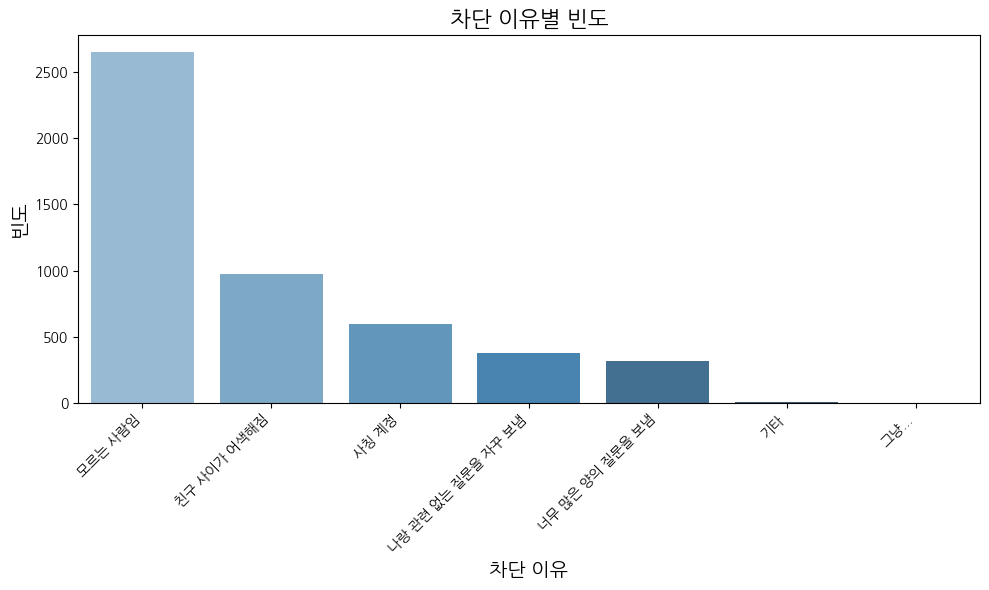

In [58]:

# 시각화를 위해 데이터 준비
reason_counts = duplicated_blockrecord_blockuser['reason'].value_counts().reset_index()
reason_counts.columns = ['reason', 'count']

# 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(data=reason_counts, x='reason', y='count', palette='Blues_d')

# 제목 및 축 이름 설정
plt.title('차단 이유별 빈도', fontsize=16)
plt.xlabel('차단 이유', fontsize=14)
plt.ylabel('빈도', fontsize=14)

# x축 레이블 각도 조정
plt.xticks(rotation=45, ha='right')

# 그래프 보기 좋게 조정
plt.tight_layout()

# 그래프 출력
plt.show()

#### 3. accounts_failpaymenthistory (상품 구매 실패 기록 테이블)

In [35]:
blob = bucket.blob('votes/accounts_failpaymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
failpaymenthistory = pd.read_parquet(io.BytesIO(parquet_bytes))
failpaymenthistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.200,A,2023-05-14 05:49:22,1055891
1,7,heart.777,A,2023-05-14 08:17:21,1152151
2,8,heart.777,A,2023-05-14 10:11:46,986200
3,9,heart.1000,A,2023-05-14 11:53:09,1028261
4,10,heart.777,A,2023-05-14 12:30:47,1235730


In [36]:
failpaymenthistory.shape

(163, 5)

In [37]:
failpaymenthistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          163 non-null    int64         
 1   productId   56 non-null     object        
 2   phone_type  163 non-null    object        
 3   created_at  163 non-null    datetime64[ns]
 4   user_id     163 non-null    int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 6.5+ KB


In [38]:
failpaymenthistory.isnull().sum()

id              0
productId     107
phone_type      0
created_at      0
user_id         0
dtype: int64

In [39]:
failpaymenthistory[failpaymenthistory['productId'].isnull()]

,id,productId,phone_type,created_at,user_id
12,20,None,I,2023-05-15 16:26:51,1153256
13,21,None,I,2023-05-16 03:16:37,1230712
14,22,None,I,2023-05-16 06:40:04,1277817
15,23,None,I,2023-05-16 07:40:32,1254768
18,26,None,I,2023-05-16 11:31:51,1189806
...,...,...,...,...,...
155,167,None,I,2023-07-04 13:42:28,1575434
156,168,None,I,2023-07-12 12:14:11,925534
159,171,None,I,2023-08-12 11:26:59,1556867
161,173,None,I,2023-09-17 09:12:53,927108


In [40]:
failpaymenthistory['phone_type'].value_counts()

phone_type
I    107
A     56
Name: count, dtype: int64

In [41]:
failpaymenthistory['user_id'].nunique()

160

In [42]:
failpaymenthistory[failpaymenthistory.duplicated('user_id', keep = False)]

,id,productId,phone_type,created_at,user_id
52,60,None,I,2023-05-19 13:38:05,1322662
53,61,None,I,2023-05-19 13:38:32,1322662
136,146,None,I,2023-05-31 12:37:45,1211047
137,147,None,I,2023-05-31 12:38:35,1211047
161,173,None,I,2023-09-17 09:12:53,927108
162,174,None,I,2023-09-17 09:12:53,927108


#### 4. accounts_friendrequest (친구 요청 테이블)

In [43]:
blob = bucket.blob('votes/accounts_friendrequest.parquet')
parquet_bytes = blob.download_as_bytes()
friendrequest = pd.read_parquet(io.BytesIO(parquet_bytes))
friendrequest.head()

,id,status,created_at,updated_at,receive_user_id,send_user_id
0,7,P,2023-04-17 18:29:11,2023-04-17 18:29:11,831962,837521
1,10,A,2023-04-17 18:29:11,2023-04-22 06:02:53,832151,837521
2,11,A,2023-04-17 18:29:11,2023-04-18 19:28:41,832340,837521
3,13,A,2023-04-17 18:29:11,2023-04-19 11:05:04,833041,837521
4,20,P,2023-04-17 18:29:11,2023-04-17 18:29:11,834415,837521


In [44]:
friendrequest.shape

(17147175, 6)

In [45]:
friendrequest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17147175 entries, 0 to 17147174
Data columns (total 6 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   status           object        
 2   created_at       datetime64[ns]
 3   updated_at       datetime64[ns]
 4   receive_user_id  int64         
 5   send_user_id     int64         
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 784.9+ MB


In [46]:
friendrequest.isnull().sum()

id                 0
status             0
created_at         0
updated_at         0
receive_user_id    0
send_user_id       0
dtype: int64

In [ ]:
# 친구 요청의 경우 한 유저가 여러 명의 유저에게 요청을 보낼 수 있음
# but send와 receive, status가 모드 같은 경우는 created_at과 updated_at의 상태를 살펴봐야함
# receive_user_id와 send_user_id가 같아 중복같지만 creqated_at과 updated_at이 중복이 아닐 경우 
# 첫 번째 친구 요청에서 거절 당한 후 재친구 요청일 수 있음
# 중복 요청이 있는데 모두 status가 R인 경우 악성 유저 아닌가....
# R -> A / P -> A => 이런 경우 존재하면 마지막 A인 경우만 남겨도?

friendrequest['status'].value_counts()

status
A    12878407
P     3938608
R      330160
Name: count, dtype: int64

In [ ]:
# send, receive, status 모두 같은 그룹별 중복 확인 
friendrequest_duplicates = friendrequest[
    friendrequest.duplicated(subset=['status', 'receive_user_id', 'send_user_id'], keep=False)
].sort_values(by=['receive_user_id', 'send_user_id', 'status'])

In [65]:
friendrequest_duplicates

,id,status,created_at,updated_at,receive_user_id,send_user_id
61330,81812,R,2023-04-24 09:27:25,2023-04-24 14:22:00,833376,844668
70722,94429,R,2023-04-25 05:02:46,2023-04-30 14:46:32,833376,844668
14187782,16328211,R,2023-05-25 01:37:36,2023-05-26 08:13:43,833673,1039406
15318771,17634582,R,2023-05-28 00:34:21,2023-05-29 14:58:41,833673,1039406
267741,345642,R,2023-04-30 15:05:54,2023-05-04 09:27:45,833714,852252
...,...,...,...,...,...,...
17140279,19685779,A,2024-03-11 14:34:21,2024-03-14 06:40:00,1583250,1583252
17141511,19687036,P,2024-03-19 14:56:09,2024-03-19 14:56:09,1583317,1583280
17141513,19687038,P,2024-03-19 14:56:11,2024-03-19 14:56:11,1583317,1583280
17142221,19687811,A,2024-03-23 08:51:38,2024-03-28 04:27:37,1583414,1568016


In [68]:
# 친구 요청 여러 번 거절 당한 유저들
friendrequest_reject = friendrequest_duplicates[friendrequest_duplicates['status'] == 'R']
friendrequest_reject

,id,status,created_at,updated_at,receive_user_id,send_user_id
61330,81812,R,2023-04-24 09:27:25,2023-04-24 14:22:00,833376,844668
70722,94429,R,2023-04-25 05:02:46,2023-04-30 14:46:32,833376,844668
14187782,16328211,R,2023-05-25 01:37:36,2023-05-26 08:13:43,833673,1039406
15318771,17634582,R,2023-05-28 00:34:21,2023-05-29 14:58:41,833673,1039406
267741,345642,R,2023-04-30 15:05:54,2023-05-04 09:27:45,833714,852252
...,...,...,...,...,...,...
17094358,19638308,R,2023-09-26 13:26:52,2023-09-26 14:12:14,1580700,1580679
17095216,19639231,R,2023-09-27 11:14:55,2023-09-28 00:41:42,1580700,1580679
17096373,19640434,R,2023-09-28 11:54:30,2023-09-30 10:34:05,1580700,1580679
17094161,19638105,R,2023-09-26 12:22:43,2023-09-26 14:12:22,1580700,1580758


In [ ]:
# 친구 요청 거절 당한 유저들 중 여러번 거절 당한 유저들 -> 유저들 차단 당한 기록이 있나 확인 필요(왜 거절 당했을까?)
friendrequest_reject['send_user_id'].nunique()

26501

In [ ]:
# 중복 친구 요청 : 처음에는 R -> A / P -> A =>이런 경우 존재하면 마지막 A인 경우만 남겨도?


#### 5. accounts_group (학급 테이블)

In [77]:
blob = bucket.blob('votes/accounts_group.parquet')
parquet_bytes = blob.download_as_bytes()
group = pd.read_parquet(io.BytesIO(parquet_bytes))
group.head()

,id,grade,class_num,school_id
0,1,1,1,1
1,8,3,2,1
2,9,3,3,1
3,10,2,2,1
4,11,2,3,1


In [94]:
group.shape

(84515, 4)

In [93]:
group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84515 entries, 0 to 84514
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   id         84515 non-null  int64
 1   grade      84515 non-null  int64
 2   class_num  84515 non-null  int64
 3   school_id  84515 non-null  int64
dtypes: int64(4)
memory usage: 2.6 MB


In [80]:
group['school_id'].value_counts()

school_id
3283    49
1773    44
1492    44
2212    43
271     43
        ..
3584     1
1324     1
2953     1
4070     1
1135     1
Name: count, Length: 5604, dtype: int64

In [ ]:
group['school_id'].nunique()

5604

In [ ]:
# 학년 4와 1은 이상치처리해서 제거하기
group['grade'].value_counts()

grade
2     35581
3     29273
1     19659
4         1
20        1
Name: count, dtype: int64

#### 6. accounts_nearbyschool (가까운 학교를 기록해두기 위한 관계형 테이블)

In [82]:
blob = bucket.blob('votes/accounts_nearbyschool.parquet')
parquet_bytes = blob.download_as_bytes()
nearbyschool = pd.read_parquet(io.BytesIO(parquet_bytes))
nearbyschool.head()

,id,distance,nearby_school_id,school_id
0,119021,0.004564,6,7
1,119022,0.010787,13,7
2,119023,0.012928,20,7
3,119024,0.013590,4,7
4,119025,0.014122,24,7


In [87]:
nearbyschool.shape

(59500, 4)

In [88]:
nearbyschool.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59500 entries, 0 to 59499
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                59500 non-null  int64  
 1   distance          59500 non-null  float64
 2   nearby_school_id  59500 non-null  int64  
 3   school_id         59500 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.8 MB


In [85]:
nearbyschool['school_id'].nunique()

5950

#### 7. accounts_paymenthistory (구매 기록 테이블)

In [89]:
blob = bucket.blob('votes/accounts_paymenthistory.parquet')
parquet_bytes = blob.download_as_bytes()
paymetnhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
paymetnhistory.head()

,id,productId,phone_type,created_at,user_id
0,6,heart.777,A,2023-05-13 21:28:34,1211127
1,7,heart.777,A,2023-05-13 21:29:39,1151343
2,8,heart.777,A,2023-05-13 21:31:33,1002147
3,9,heart.777,A,2023-05-13 21:31:39,1095040
4,11,heart.777,A,2023-05-13 21:34:32,1164081


In [90]:
paymetnhistory.shape

(95140, 5)

In [91]:
paymetnhistory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95140 entries, 0 to 95139
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          95140 non-null  int64         
 1   productId   95140 non-null  object        
 2   phone_type  95140 non-null  object        
 3   created_at  95140 non-null  datetime64[ns]
 4   user_id     95140 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 3.6+ MB


In [95]:
paymetnhistory['productId'].value_counts()

productId
heart.777     57873
heart.1000    19309
heart.200     15822
heart.4000     2136
Name: count, dtype: int64

#### 8. accounts_user_contacts (유저 컨택 테이블)

In [96]:
blob = bucket.blob('votes/accounts_user_contacts.parquet')
parquet_bytes = blob.download_as_bytes()
user_contacts = pd.read_parquet(io.BytesIO(parquet_bytes))
user_contacts.head()

,id,contacts_count,invite_user_id_list,user_id
0,259,30,[],1167696
1,1756,79,[],863169
2,13742,21,[854615],857205
3,13754,29,[],851431
4,13756,28,[849318],855476


In [97]:
user_contacts.shape

(5063, 4)

In [99]:
user_contacts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5063 entries, 0 to 5062
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   5063 non-null   int64 
 1   contacts_count       5063 non-null   int64 
 2   invite_user_id_list  5063 non-null   object
 3   user_id              5063 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 158.3+ KB


In [ ]:
# [] 이 경우 
user_contacts['invite_user_id_list'].value_counts()

invite_user_id_list
[]                          3905
[1154585]                     15
[1233225]                     12
[1041381]                      9
[936990]                       7
                            ... 
[881077, 879139, 884682]       1
[873550]                       1
[880105]                       1
[873001, 885619]               1
[1461877]                      1
Name: count, Length: 928, dtype: int64

#### 9. accounts_pointhistory (포인트 기록 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_pointhistory.parquet')
parquet_bytes = blob.download_as_bytes()
pointhistory = pd.read_parquet(io.BytesIO(parquet_bytes))
pointhistory.head()

#### 10. accounts_school (학교 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_school.parquet')
parquet_bytes = blob.download_as_bytes()
school = pd.read_parquet(io.BytesIO(parquet_bytes))
school.head()

#### 11. accounts_timelineReport (유저 신고기록 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_timelinereport.parquet')
parquet_bytes = blob.download_as_bytes()
timelineReport = pd.read_parquet(io.BytesIO(parquet_bytes))
timelineReport.head()

#### 12. accounts_user (유저 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_user.parquet')
parquet_bytes = blob.download_as_bytes()
user = pd.read_parquet(io.BytesIO(parquet_bytes))
user.head()

#### 13. accounts_userquestionrecord (투표 기록 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_userquestionrecord.parquet')
parquet_bytes = blob.download_as_bytes()
userquestionrecord = pd.read_parquet(io.BytesIO(parquet_bytes))
userquestionrecord.head()

#### 14. accounts_userwithdraw (탈퇴 기록 테이블)

In [ ]:
blob = bucket.blob('votes/accounts_userwithdraw.parquet')
parquet_bytes = blob.download_as_bytes()
userwithdraw = pd.read_parquet(io.BytesIO(parquet_bytes))
userwithdraw.head()

#### 15. event_receipts (포인트 이벤트 참여 테이블)

In [ ]:
blob = bucket.blob('votes/event_receipts.parquet')
parquet_bytes = blob.download_as_bytes()
receipts = pd.read_parquet(io.BytesIO(parquet_bytes))
receipts.head()

#### 16. events (포인트 이벤트 테이블)

In [ ]:
blob = bucket.blob('votes/events.parquet')
parquet_bytes = blob.download_as_bytes()
events = pd.read_parquet(io.BytesIO(parquet_bytes))
events.head()

#### 17. polls_question (질문 내용 테이블)




In [70]:
blob = bucket.blob('votes/polls_question.parquet')
parquet_bytes = blob.download_as_bytes()
polls_question = pd.read_parquet(io.BytesIO(parquet_bytes))
polls_question.head()

,id,question_text,created_at
0,99,가장 신비한 매력이 있는 사람은?,2023-03-31 15:22:53
1,100,"""이 사람으로 한 번 살아보고 싶다"" 하는 사람은?",2023-03-31 15:22:53
2,101,미래의 틱톡커는?,2023-03-31 15:22:54
3,102,여기서 제일 특이한 친구는?,2023-03-31 15:22:54
4,103,가장 지켜주고 싶은 사람은?,2023-03-31 15:22:55


In [73]:
polls_question.shape

(5025, 3)

#### 18. polls_questionpiece (질문 테이블)

In [74]:
blob = bucket.blob('votes/polls_questionpiece.parquet')
parquet_bytes = blob.download_as_bytes()
questionpiece = pd.read_parquet(io.BytesIO(parquet_bytes))
questionpiece.head()

,id,is_voted,created_at,question_id,is_skipped
0,998458,1,2023-04-28 12:27:22,252,0
1,998459,1,2023-04-28 12:27:22,244,0
2,998460,1,2023-04-28 12:27:22,183,0
3,998461,1,2023-04-28 12:27:22,101,0
4,998462,1,2023-04-28 12:27:22,209,0


In [76]:
questionpiece.shape

(1265476, 5)

#### 19. polls_questionreport (질문에 대한 신고 기록 테이블)

In [ ]:
blob = bucket.blob('votes/polls_questionreport.parquet')
parquet_bytes = blob.download_as_bytes()
questionreport = pd.read_parquet(io.BytesIO(parquet_bytes))
questionreport.head()

#### 20. polls_questionset (질문 세트 테이블)

In [71]:
blob = bucket.blob('votes/polls_questionset.parquet')
parquet_bytes = blob.download_as_bytes()
questionset = pd.read_parquet(io.BytesIO(parquet_bytes))
questionset.head()

,id,question_piece_id_list,opening_time,status,created_at,user_id
0,99817,"[998458, 998459, 998460, 998461, 998462, 99846...",2023-04-28 12:27:22,F,2023-04-28 12:27:23,849436
1,99830,"[998588, 998589, 998590, 998591, 998592, 99859...",2023-04-28 12:28:07,F,2023-04-28 12:28:07,849438
2,99840,"[998689, 998691, 998693, 998695, 998697, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,847375
3,99841,"[998688, 998690, 998692, 998694, 998696, 99869...",2023-04-28 12:28:38,F,2023-04-28 12:28:38,849446
4,99848,"[998768, 998769, 998770, 998771, 998772, 99877...",2023-04-28 12:28:57,F,2023-04-28 12:28:57,849477


#### 21. polls_usercandidate (질문에 등장하는 유저들 테이블)

In [72]:
blob = bucket.blob('votes/polls_usercandidate.parquet')
parquet_bytes = blob.download_as_bytes()
usercandidate = pd.read_parquet(io.BytesIO(parquet_bytes))
usercandidate.head()

,id,created_at,question_piece_id,user_id
0,3088872,2023-04-28 12:27:49,998458,849444
1,3088873,2023-04-28 12:27:49,998458,849454
2,3088874,2023-04-28 12:27:49,998458,849460
3,3088875,2023-04-28 12:27:49,998458,849469
4,3088964,2023-04-28 12:28:02,998459,849446
